# Results Optiwise inverse dynamics

In [309]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [448]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from phd.visualization.styles import styles
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from vessel_manoeuvring_models import IMO_evaluation
from sklearn.metrics import mean_squared_error, r2_score

In [311]:
ship_name = "optiwise"

In [312]:
#%reload_kedro

#%reload_kedro
loaders = {f"polynomial rudder {name}":loader for name,loader in catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL").items()}
#loader={}
loaders["semiempirical rudder"] = catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia']
loaders["measured rudder"] = catalog.load(f"{ship_name}.models_measured_rudder_force")['semiempirical_covered_inertia']
loaders["MMG_rudder"] = catalog.load(f"{ship_name}.models_VCT_MMG_rudder_MDL")["MMG"]
loaders.pop('polynomial rudder complex')  # for now...

ship_data = catalog.load(f"{ship_name}.ship_data")

[11/15/24 13:49:21] INFO     Loading data from 'optiwise.models_VCT_polynomial_rudder_MDL'      ]8;id=364257;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=927363;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MDL'                        ]8;id=12583;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=5028;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_measured_rudder_force'          ]8;id=134647;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=912058;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MMG_rudder_MDL'             ]8;id=635801;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=914860;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.ship_data' (YAMLDataSet)...            ]8;id=934286;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=324623;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [313]:
models = {name:loader() for name,loader in loaders.items()}
model = models["semiempirical rudder"]

In [314]:
meta_datas_all = catalog.load(f"{ship_name}.test_meta_data")

meta_datas_all = meta_datas_all.groupby('test_type').get_group('zigzag')
mask = meta_datas_all['ship_speed'] > 0.9
meta_datas_all = meta_datas_all.loc[mask].copy()

[11/15/24 13:49:25] INFO     Loading data from 'optiwise.test_meta_data' (CSVDataSet)...        ]8;id=97890;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=168308;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [315]:
meta_datas = meta_datas_all.loc[[23590, 23591, 23594, 23596]].copy()

## Compare forces

In [316]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
#model = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']()
df_VCT_hydro = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'optiwise.df_VCT_scaled' (CSVDataSet)...         ]8;id=264032;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=327501;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [491]:
round = {
    'u':4,
    'v':4,
    'r':4,
    'delta':4,
}

keys_rounded = [f"{key}_round" for key in round.keys()]

for key,decimals in round.items():
    df_VCT_hydro[f"{key}_round"] = np.round(df_VCT_hydro[key], decimals=decimals)

_=[]
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    for key,decimals in round.items():
        df_EKF_smooth[f"{key}_round"] = np.round(df_EKF_smooth[key], decimals=decimals)

    df_EKF_smooth['time'] = df_EKF_smooth.index

    points = pd.merge(left=df_EKF_smooth, right=df_VCT_hydro, how='inner', left_on=keys_rounded, right_on=keys_rounded, suffixes=('','_vct'))
    points.set_index('time', inplace=True)
    assert points.index.is_unique
    points['id'] = id
    #points_all[id]=points
    _.append(points)

points_all = pd.concat(_)
points_all['id'] = points_all['id'].astype(int)

[11/18/24 17:41:08] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=888493;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=758718;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=764364;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=591359;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=567496;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=863112;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=899530;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=771331;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [492]:
styles['polynomial rudder simple'] = styles['polynomial rudder']
styles['polynomial rudder complex'] = {'style':'m-','label':'complex'}

In [493]:
#models['MMG_rudder'].parameters['l_R']=1*-4.3047794115

[11/18/24 17:43:17] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=608418;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=857007;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=147639;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=344101;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/18/24 17:43:18] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=878889;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=333195;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[11/18/24 17:43:19] INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=632724;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=396884;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

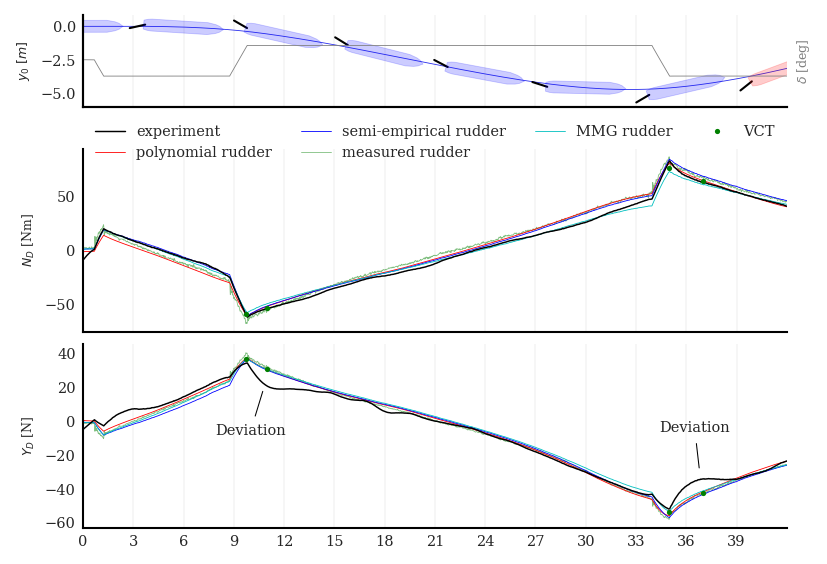

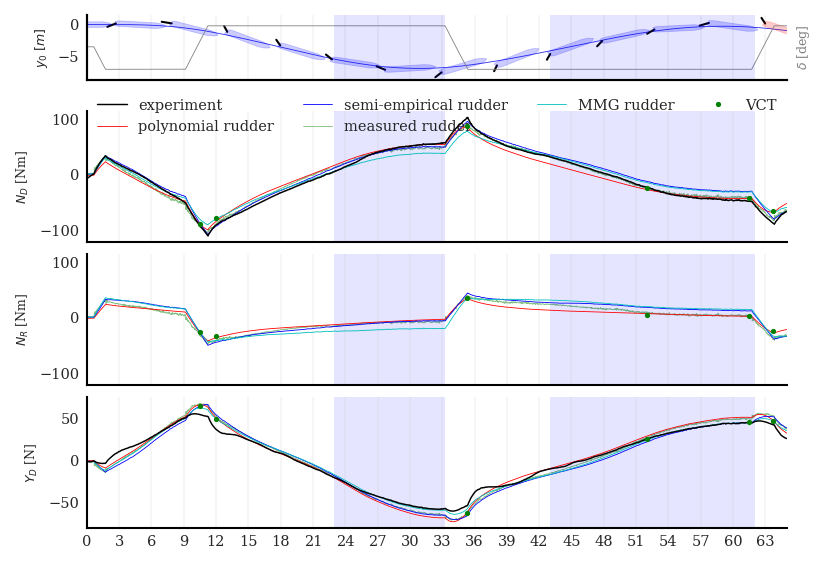

In [497]:
t_maxs = {
    23590 : 42, 
    23594 : 65,
}

for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha']
    if id==23590:
        keys=['N_D','Y_D',]
    else:
        keys=['N_D','N_R','Y_D',]
    fig = plot_compare_model_forces(model=model, models=models, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units, symbols=symbols);
    
    

    
    for ax in fig.axes[1:5]:
        ylims = ax.get_ylim()
        ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
        ax.set_ylim(ylims)
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)


    if id==23594:
        for i,ax in enumerate(fig.axes):

            if i==0:
                continue
            
            ylims = ax.get_ylim()
            ax.fill([43,43,62,62], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)

        for i,ax in enumerate(fig.axes):

            if i==0:
                continue
            
            ylims = ax.get_ylim()
            ax.fill([23,23,33.3,33.3], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)

    if id==23590:
        fig.axes[2].annotate("Deviation", xy=(10.8,20), xytext=(10,-10), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='bottom')

        fig.axes[2].annotate("Deviation", xy=(36.8,-30), xytext=(36.5,0), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='top')

        
    
    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.50, 1.20), ncol=4)


    
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')

    fig.set_size_inches(paper.figure_width,1.2*paper.figure_height)
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")
    

In [441]:
data = df_EKF_smooth
forces_from_motions = model.forces_from_motions(data=data)
force_predictions = {name:predict(model=model, data=data) for name, model in models.items()}

In [455]:
keys = ['Y_D','N_D']
_ = []
for name, df_prediction in force_predictions.items():
    score = pd.Series(name=name)
    for key in keys:
        score[key] = np.sqrt(mean_squared_error(y_true=forces_from_motions[key], y_pred=df_prediction[key]))

    _.append(score)

scores = pd.DataFrame(_)


In [462]:
scores

,Y_D,N_D
polynomial rudder simple,6.001311,8.945992
semiempirical rudder,7.037559,7.921405
measured rudder,6.231705,5.398719
MMG_rudder,4.736209,10.321409


<Axes: >

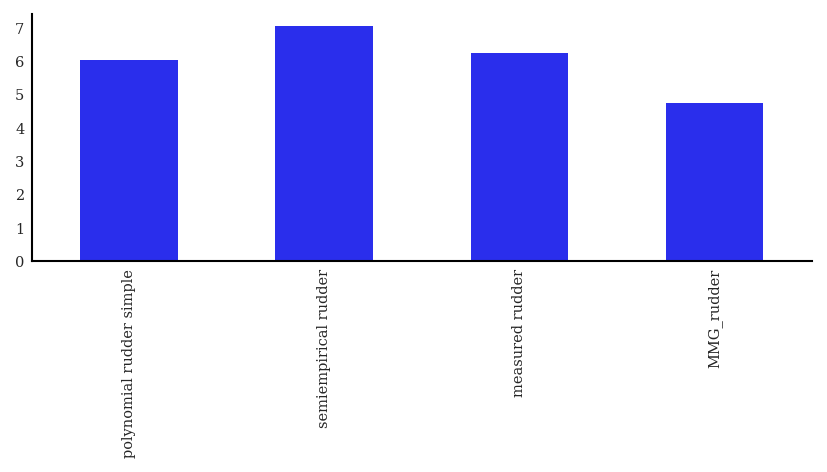

In [461]:
scores['Y_D'].plot.bar()

<Axes: >

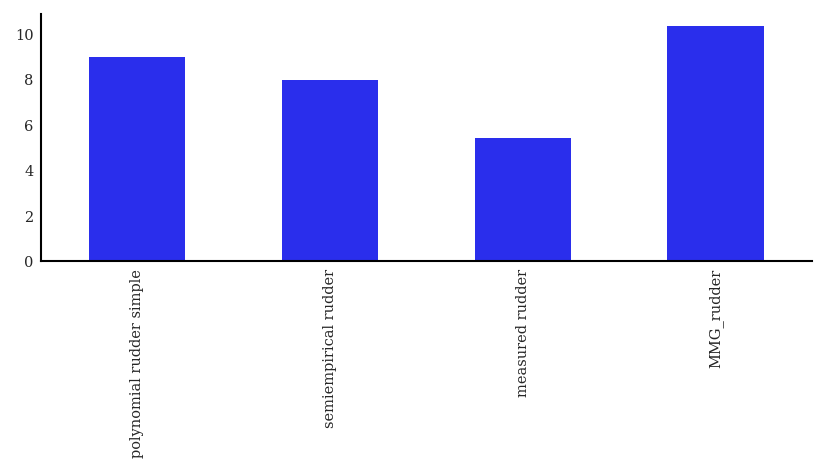

In [463]:
scores['N_D'].plot.bar()

<Axes: >

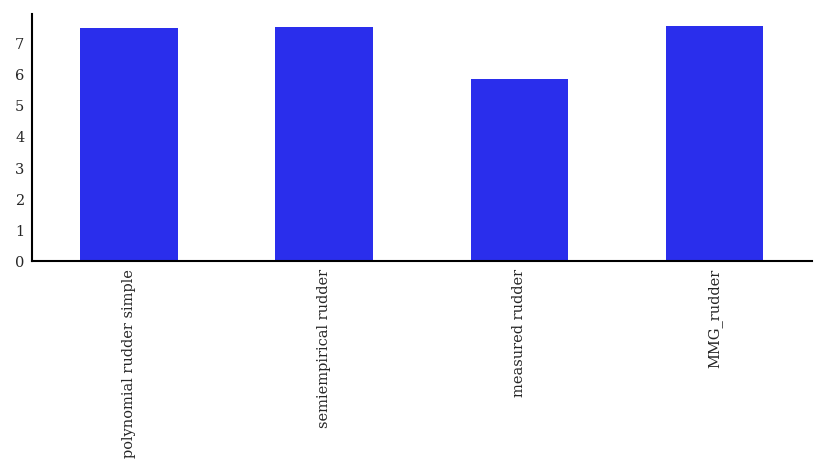

In [466]:
scores.mean(axis=1).plot.bar()

## Closed loop simulation

[11/18/24 07:51:55] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=48279;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=82413;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=519098;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=485220;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/18/24 07:51:59] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=278069;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=386906;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=468004;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=899984;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/18/24 07:52:03] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=427745;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=319069;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=924539;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=189432;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=982627;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=55497;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/18/24 07:52:06] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=347800;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=553893;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=255820;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=403465;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/18/24 07:52:09] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=63174;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=804517;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

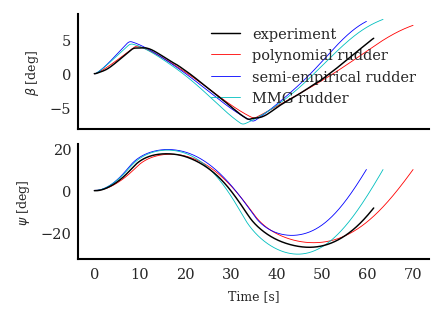

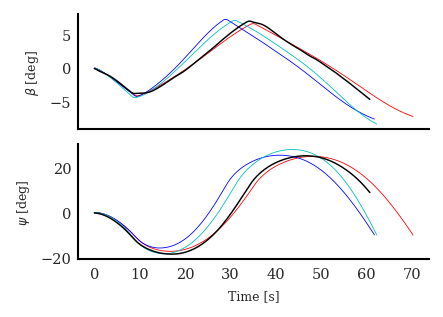

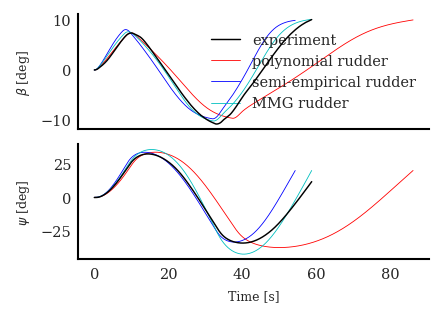

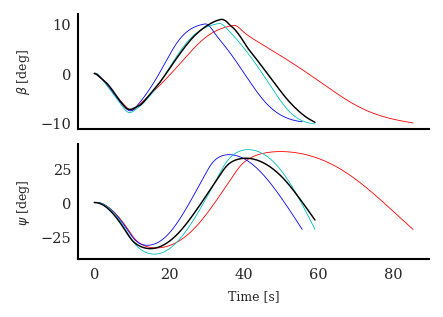

In [404]:
simulations = {}

for angle, group in meta_datas.groupby(by='angle1'):

    #fig,ax=plt.subplots()
    include_label=True
    
    for id, meta_data in group.iterrows():
    
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
        df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
        df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
        df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
        df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
        df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    
        dataframes = {'Experiment':df_EKF_smooth}
        
        for model_name, model in models.items():

            data = preprocess(df_EKF_smooth,ship_data=model.ship_parameters)
            angle = zigzag_angle(data_MDL=data)
        
            if model_name == "measured rudder":
                #df_simulation = model.simulate(data)
                continue
            else:
                df_simulation = simulate_closed_loop(model=model,data=data)

            if not id in simulations:
                simulations[id] = {}

            simulations[id][model_name] = df_simulation
            
            direction = "port" if angle > 0 else "stbd"
            name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction} {model_name}"
        
            dataframes[model_name] = df_simulation

        dataframes['Experiment'] = dataframes['Experiment'].loc[-1:df_simulation.index[-1]].copy()
        
        #track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], include_wind=False, styles=styles, ax=ax, include_label=include_label);
        #fig = ax.get_figure()
        
        direction = "port" if angle > 0 else "stbd"
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
        #fig.suptitle(name)
        #file_name = name.replace("/","_")
        #paper.save_fig(fig, f"track plot {file_name}.svg")
        
        fig = plot(dataframes, keys=['psi','beta'], units=units, styles=styles, ncols=1, include_label=include_label, symbols=symbols);
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
        for ax in fig.axes:
            ax.grid(False)

        fig.set_size_inches(paper.figure_width/2,paper.figure_height*2/3)
        
        #fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"closed loop {file_name}.svg")
        
        
        include_label=False

In [405]:
mask = pd.notnull(meta_datas_all['angle'])
meta_datas_all = meta_datas_all.loc[mask].copy()

meta_datas_all[['angle','comment']]

,angle,comment
23590,-10.0,ZZ10/10 SB
23591,10.0,ZZ10/10 SB
23592,-10.0,ZZ10/10 SB
23593,10.0,ZZ10/10 PS
23594,-20.0,ZZ20/20 SB
23595,-20.0,ZZ20/20 SB
23596,20.0,ZZ20/20 PS
23597,20.0,ZZ20/20 PS
23679,-10.0,ZZ10/10 SB
23680,10.0,ZZ10/10 PS


In [406]:
IMO_evaluation.measure_overshoots(df_simulation)


16.05    18.216256
41.18    18.837355
Name: psi, dtype: float64

In [407]:
IMO_evaluation.measure_overshoots(df_EKF_smooth)


time
14.979986    14.046294
40.589996    12.413888
67.979999    12.360698
Name: psi, dtype: float64

In [408]:
def pack_overshoots(overshoots):
    overshoot_result = {}
    for n,(time, overshoot) in enumerate(overshoots.items()):  
        overshoot_result[f'overshoot_{n+1}'] = overshoot
        overshoot_result[f't_{n+1}'] = time

    return overshoot_result

In [409]:
_ = []
for id, meta_data in meta_datas_all.iterrows():
    
    try:
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    except:
        continue
    #df_EKF_smooth = catalog.load(f"{ship_name}.tests")[str(id)]()
    
    overshoots = IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=meta_data['angle'])
    overshoot_result = pack_overshoots(overshoots)
    overshoot_result = pd.Series(overshoot_result, name=id)
    overshoot_result['angle'] = meta_data['angle']
    
    
    _.append(overshoot_result)
    
overshoot_results = pd.DataFrame(_)

[11/18/24 07:52:10] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=349752;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=151626;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=174996;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=12112;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=983302;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=674899;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=325113;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=973771;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=659669;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=824113;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=65279;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=171811;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[11/18/24 07:52:11] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=487707;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=671368;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=374412;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=38580;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=825769;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=172682;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=537560;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=751400;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=103854;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=482734;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=685720;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=671189;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [410]:
overshoot_results.sort_values(by='angle')

,overshoot_1,t_1,overshoot_2,t_2,angle,overshoot_3,t_3
23594,12.275516,15.180002,13.988310,40.799998,-20.0,10.929683,68.279999
23595,12.687193,15.399989,14.028674,41.460002,-20.0,10.805342,68.809988
23682,12.451062,15.340005,13.836021,41.039996,-20.0,11.003151,68.630016
23590,7.432821,16.550008,17.138650,47.909988,-10.0,NaN,NaN
23592,7.625012,17.079992,17.168450,47.769985,-10.0,NaN,NaN
23679,7.886254,17.329988,17.687529,49.059983,-10.0,NaN,NaN
23591,8.464648,17.709999,15.291949,47.250018,10.0,NaN,NaN
23593,8.537342,17.669989,15.042208,47.099989,10.0,NaN,NaN
23680,8.724413,17.660002,14.986429,47.369995,10.0,NaN,NaN
23596,14.046294,15.659982,12.413888,41.269992,20.0,12.360698,68.659995


In [411]:
meta_data['angle']

-20.0

In [412]:
overshoot_results['id'] = overshoot_results.index

<Axes: xlabel='id'>

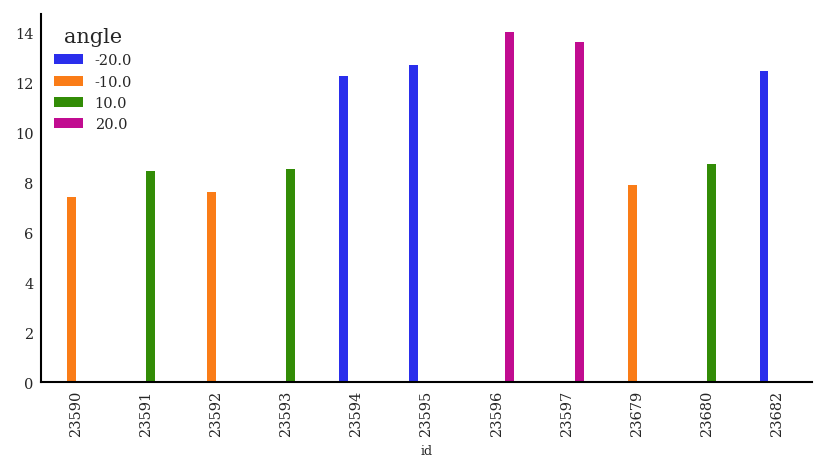

In [413]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').transpose().plot.bar()

<Axes: xlabel='angle'>

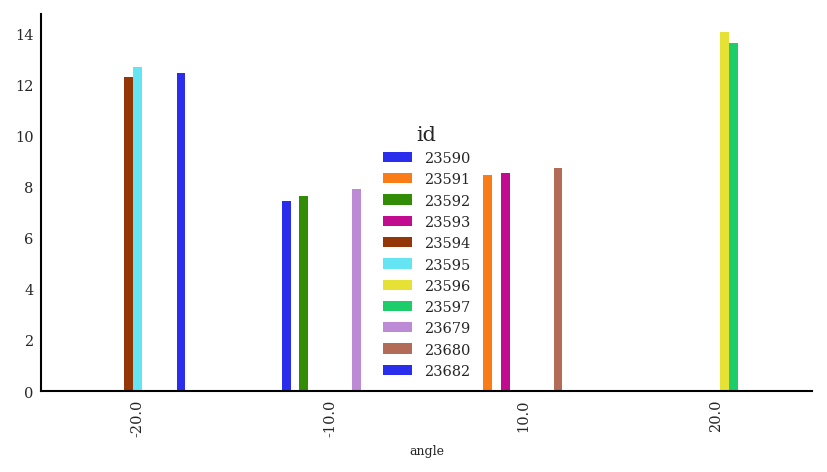

In [414]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').plot.bar()

In [415]:
overshoot_experiment_mean = overshoot_results.groupby(by='angle').mean()
overshoot_experiment_mean['model_name'] = 'Experiment'
overshoot_experiment_mean['angle'] = overshoot_experiment_mean.index

In [416]:
overshoot_results.groupby(by='angle').std()

,overshoot_1,t_1,overshoot_2,t_2,overshoot_3,t_3,id
angle,,,,,,,
-20.0,0.206580,0.113720,0.101601,0.334068,0.099988,0.269503,50.520623
-10.0,0.227591,0.398278,0.308653,0.707835,NaN,NaN,50.816664
10.0,0.134014,0.026458,0.162699,0.135281,NaN,NaN,50.816664
20.0,0.302530,0.070699,0.168781,0.127267,0.155845,0.028285,0.707107


In [417]:
_ = []
for id, model_simulations in simulations.items():

    meta_data = meta_datas_all.loc[id]
    
    for model_name, df_simulation in model_simulations.items():
        
        overshoots = IMO_evaluation.measure_overshoots(df_simulation, angle=meta_data['angle'])
        overshoot_result = pack_overshoots(overshoots)
        overshoot_result['id'] = id
        overshoot_result['model_name'] = model_name
        overshoot_result['angle'] = meta_data['angle']
        _.append(overshoot_result)
    
overshoot_simulation_results = pd.DataFrame(_)
overshoot_simulation_results = pd.concat((overshoot_simulation_results,overshoot_experiment_mean,))

In [418]:
overshoot_simulation_results['angle'] = overshoot_simulation_results['angle'].astype(int)

In [419]:
overshoot_simulation_results

,overshoot_1,t_1,overshoot_2,t_2,id,model_name,angle,overshoot_3,t_3
0.0,7.304777,16.760000,15.020078,48.190000,23590.000000,polynomial rudder simple,-10,NaN,NaN
1.0,9.562100,16.160000,11.516707,43.400000,23590.000000,semiempirical rudder,-10,NaN,NaN
2.0,9.260561,16.060000,20.495009,44.730000,23590.000000,MMG_rudder,-10,NaN,NaN
3.0,7.299680,16.730000,15.125244,48.240000,23591.000000,polynomial rudder simple,10,NaN,NaN
4.0,5.807517,14.440000,15.641343,40.890000,23591.000000,semiempirical rudder,10,NaN,NaN
5.0,8.396903,15.380000,18.185290,43.610000,23591.000000,MMG_rudder,10,NaN,NaN
6.0,13.638056,16.560000,17.436026,50.070000,23594.000000,polynomial rudder simple,-20,NaN,NaN
7.0,13.615504,13.620000,13.330602,37.820000,23594.000000,semiempirical rudder,-20,NaN,NaN
8.0,15.652307,15.510000,22.328913,40.400000,23594.000000,MMG_rudder,-20,NaN,NaN
9.0,13.649071,16.530000,17.418249,49.880000,23596.000000,polynomial rudder simple,20,NaN,NaN


In [420]:
styles


{
    'Experiment': {'style': 'k-', 'zorder': 100, 'lw': 0.7, 'label': 'experiment'},
    'polynomial rudder': {'style': '-', 'color': 'red', 'label': 'polynomial rudder'},
    'semiempirical rudder': {'style': 'b-', 'label': 'semi-empirical rudder'},
    'measured rudder': {'style': 'g-', 'zorder': -100, 'alpha': 0.5, 'label': 'measured rudder'},
    'MMG_rudder': {'style': 'c-', 'label': 'MMG rudder'},
    'polynomial rudder simple': {'style': '-', 'color': 'red', 'label': 'polynomial rudder'},
    'polynomial rudder complex': {'style': 'm-', 'label': 'complex'}
}

In [421]:
def get_name(row):
    angle = row.name
    direction = "port" if angle > 0 else "stbd"
    name = f"{abs(angle):0.0f}/{abs(angle):0.0f} {direction}"
    return name

In [422]:
def get_colors(overshoot_simulation_results_pivot):
    colors = []
    for name in overshoot_simulation_results_pivot.columns:
        if name=='name':
            continue
    
        style= styles[name]
        color = style.get('color',style['style'][0])
        colors.append(color)
    return colors

In [489]:
df_overshoot_diff = overshoot_simulation_results_pivot.select_dtypes(exclude='object').sub(overshoot_simulation_results_pivot['Experiment'],axis=0)
df_overshoot_diff.abs().mean(numeric_only=True)


model_name
Experiment                  0.000000
MMG_rudder                  5.290655
polynomial rudder simple    2.734645
semiempirical rudder        2.452160
dtype: float64

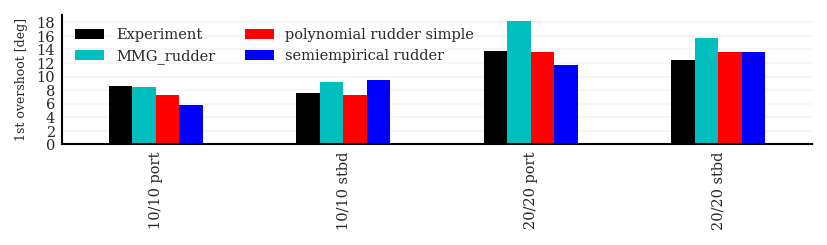

In [423]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_1')
colors = get_colors(overshoot_simulation_results_pivot)

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)
ax.legend(ncols=2)
ax.set_xlabel('')
ax.set_ylabel('1st overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot1.svg")

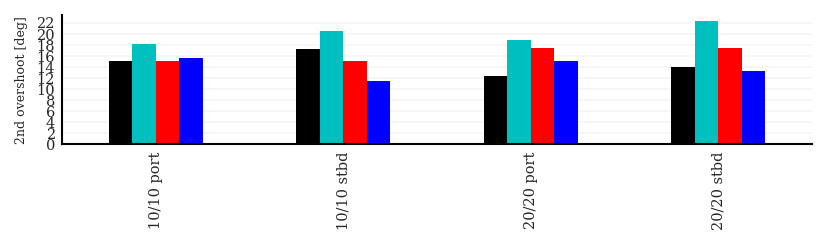

In [424]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_2')

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)

#ax.legend(ncols=3)
ax.get_legend().set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('2nd overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot2.svg")

In [425]:
overshoot_simulation_results_pivot

model_name,Experiment,MMG_rudder,polynomial rudder simple,semiempirical rudder,name
angle,,,,,
10,15.106862,18.185290,15.125244,15.641343,10/10 port
-10,17.331543,20.495009,15.020078,11.516707,10/10 stbd
20,12.294542,18.837355,17.418249,15.133466,20/20 port
-20,13.951002,22.328913,17.436026,13.330602,20/20 stbd


<Axes: >

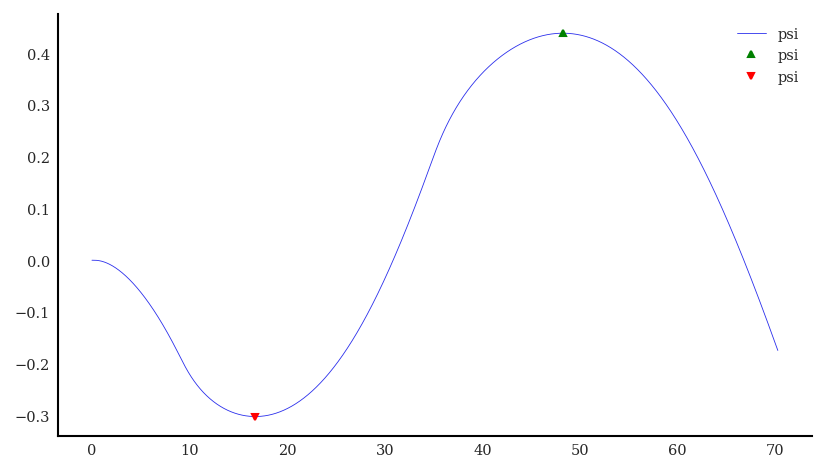

In [426]:
df_simulation = simulations[23591]['polynomial rudder simple']

maximums = IMO_evaluation.maximums(df_simulation)
minimums = IMO_evaluation.minimums(df_simulation)

fig,ax=plt.subplots()
df_simulation.plot(y='psi',ax=ax)
maximums.plot(y='psi', style='g^', ax=ax)
minimums.plot(y='psi', style='rv', ax=ax)

[11/18/24 07:52:13] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=959004;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=55905;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

<Axes: xlabel='time'>

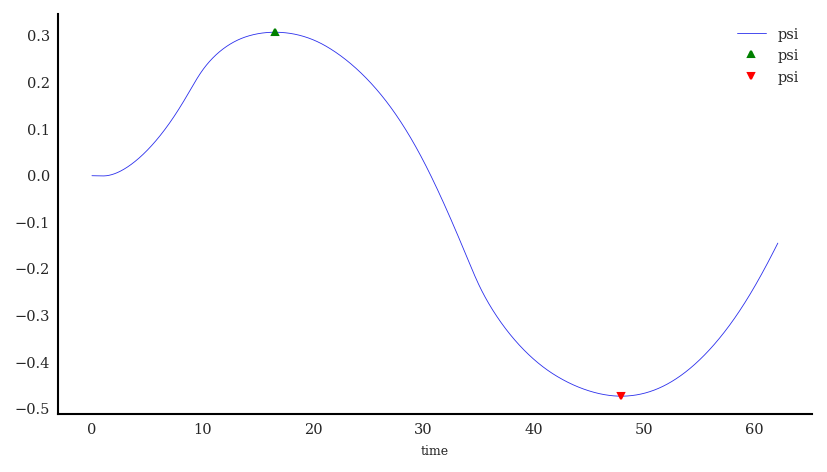

In [427]:
id = 23590
df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()

maximums = IMO_evaluation.maximums(df_EKF_smooth, angle=10)
minimums = IMO_evaluation.minimums(df_EKF_smooth, angle=10)

fig,ax=plt.subplots()
df_EKF_smooth.plot(y='psi',ax=ax)
maximums.plot(y='psi', style='g^', ax=ax)
minimums.plot(y='psi', style='rv', ax=ax)

In [428]:
meta_datas_all.loc[23590]['angle']

-10.0

In [429]:
IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=10)


time
16.550008     7.432821
47.909988    17.138650
Name: psi, dtype: float64

<Axes: xlabel='time'>

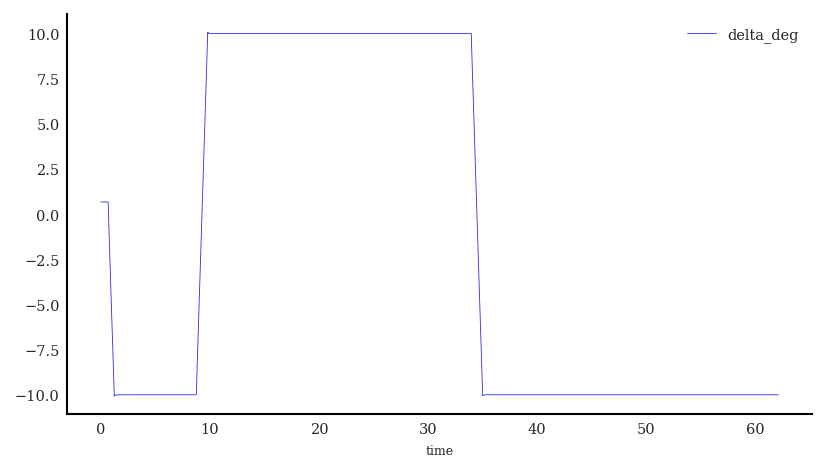

In [430]:
df_EKF_smooth['delta_deg'] = np.rad2deg(df_EKF_smooth['delta'])
df_EKF_smooth.plot(y='delta_deg')